In [9]:
import pandas as pd
import pulp as pl
import os
import yaml
import matplotlib.pyplot as plt

In [14]:
# ---------------------------------------------------
# Pfade
# ---------------------------------------------------
current_dir = os.getcwd()
archetypes_path = os.path.join(current_dir, "..\\", "..\\", "data\\archetypes_v1.xlsx")
config_path = os.path.join(current_dir, "constraints.yaml")

# ---------------------------------------------------
# 1) Daten einlesen
# ---------------------------------------------------
df = pd.read_excel(archetypes_path)
df = df.set_index("archetype_id")  # Index: Archetyp-ID [file:2]

# vorbereitete thermische Endenergie (Heizen + DHW)
df["E_therm_MWhyr"] = (
    df["E_final_heating_MWhyr"] + df["E_final_dhw_MWhyr"]
)  # [file:2]

idx = df.index.tolist()

# ---------------------------------------------------
# 2) Konfiguration einlesen
# ---------------------------------------------------
with open(config_path, "r", encoding="utf-8") as f:
    cfg = yaml.safe_load(f)

targets = cfg.get("targets", {})
weights = cfg.get("weights", {})
constraints_cfg = cfg.get("constraints", [])

In [16]:
# ---------------------------------------------------
# 3) Modell und Variablen
# ---------------------------------------------------
model = pl.LpProblem("Archetype_Inference", pl.LpMinimize)

# Gewichte / Anzahlen der Archetypen
w = pl.LpVariable.dicts("w", idx, lowBound=0, cat="Integer") # hier cat = "Continuous" für LP-Relaxation

# Slack-Variablen sammeln (pro Constraint-Name oder Gruppen-Element)
slack_pos = {}
slack_neg = {}

In [17]:
# ---------------------------------------------------
# 4) Constraints aus YAML kompilieren
# ---------------------------------------------------
for c in constraints_cfg:
    name = c["name"]
    ctype = c["type"]
    hard = c.get("hard", False)

    # Ziel(e) auflösen
    # - für 'sum' oder 'share' mit target: einfacher Wert oder String-Referenz
    # - für 'share_group' mit targets: dict in targets
    if ctype in ["sum", "share"]:
        if isinstance(c.get("target"), str):
            target_value = targets[c["target"]]
        else:
            target_value = c["target"]
    elif ctype == "share_group":
        # targets: Name des Dicts in 'targets'
        target_group_name = c["targets"]
        target_group = targets[target_group_name]
    else:
        raise ValueError(f"Unknown constraint type: {ctype}")

    # Serie/Spalte für Aggregation
    column = c["column"]
    series = df[column].astype(float)

    if ctype == "sum":
        # Summe über alle
        expr = pl.lpSum(w[i] * series[i] for i in idx)
        if hard:
            model += expr == target_value, name
        else:
            s_pos = pl.LpVariable(f"s_{name}_pos", lowBound=0)
            s_neg = pl.LpVariable(f"s_{name}_neg", lowBound=0)
            slack_pos[name] = s_pos
            slack_neg[name] = s_neg
            model += expr - target_value == s_pos - s_neg, name

    elif ctype == "share":
        predicate = c["predicate"]
        sel_idx = df.query(predicate).index
        expr_num = pl.lpSum(w[i] * series[i] for i in sel_idx)
        expr_den = pl.lpSum(w[i] * series[i] for i in idx)
        if hard:
            model += expr_num - target_value * expr_den == 0, name
        else:
            s_pos = pl.LpVariable(f"s_{name}_pos", lowBound=0)
            s_neg = pl.LpVariable(f"s_{name}_neg", lowBound=0)
            slack_pos[name] = s_pos
            slack_neg[name] = s_neg
            model += expr_num - target_value * expr_den == s_pos - s_neg, name

    elif ctype == "share_group":
        # categories: dict {cat_name: predicate}
        categories = c["categories"]
        for cat_name, predicate in categories.items():
            sub_name = f"{name}_{cat_name}"
            target_share = target_group[cat_name]

            sel_idx = df.query(predicate).index
            expr_num = pl.lpSum(w[i] * series[i] for i in sel_idx)
            expr_den = pl.lpSum(w[i] * series[i] for i in idx)

            if hard:
                model += expr_num - target_share * expr_den == 0, sub_name
            else:
                s_pos = pl.LpVariable(f"s_{sub_name}_pos", lowBound=0)
                s_neg = pl.LpVariable(f"s_{sub_name}_neg", lowBound=0)
                slack_pos[sub_name] = s_pos
                slack_neg[sub_name] = s_neg
                model += (
                    expr_num - target_share * expr_den == s_pos - s_neg
                ), sub_name

    else:
        raise ValueError(f"Unknown constraint type: {ctype}")
    
    ## ctype erweiterbar für z.B. histogram, crosstab, bound, ratio, scenario_toggle

In [18]:
# ---------------------------------------------------
# 5) Zielfunktion aus Slack-Variablen
# ---------------------------------------------------
objective_terms = []

for name in slack_pos:
    # einfache Zuordnung der Gewichte
    if name == "Af_total":
        alpha = weights.get("Af_total", 1.0)
    elif name == "share_residential_Af":
        alpha = weights.get("share_residential_Af", 1.0)
    elif name.startswith("share_energy_therm_"):
        alpha = weights.get("share_energy_therm", 1.0)
    else:
        alpha = 1.0

    objective_terms.append(alpha * (slack_pos[name] + slack_neg[name]))

if objective_terms:
    model += pl.lpSum(objective_terms)
else:
    model += 0

In [19]:
# ---------------------------------------------------
# 6) Lösen
# ---------------------------------------------------
solver = pl.PULP_CBC_CMD(timeLimit=60) # Zeitlimit in Sekunden; best-effort Lösung; wenn exakter gewünscht, Zeitlimit entfernen
model.solve(solver)

print("Status:", pl.LpStatus[model.status])
w_sol = pd.Series({i: w[i].varValue for i in idx})


Status: Optimal


                         constraint                            metric  \
0                          Af_total                            Af_sum   
1              share_residential_Af              share_residential_Af   
2         share_energy_therm_fossil         share_energy_therm_fossil   
3        share_energy_therm_biogene        share_energy_therm_biogene   
4  share_energy_therm_district_heat  share_energy_therm_district_heat   
5      share_energy_therm_heat_pump      share_energy_therm_heat_pump   

      target          model     abs_error  rel_error  
0  878085.00  878123.040000  3.804000e+01   0.000043  
1       0.61       0.609338 -6.619737e-04  -0.001085  
2       0.31       0.309995 -5.343305e-06  -0.000017  
3       0.37       0.370001  5.078484e-07   0.000001  
4       0.16       0.000000 -1.600000e-01  -1.000000  
5       0.15       0.000000 -1.500000e-01  -1.000000  


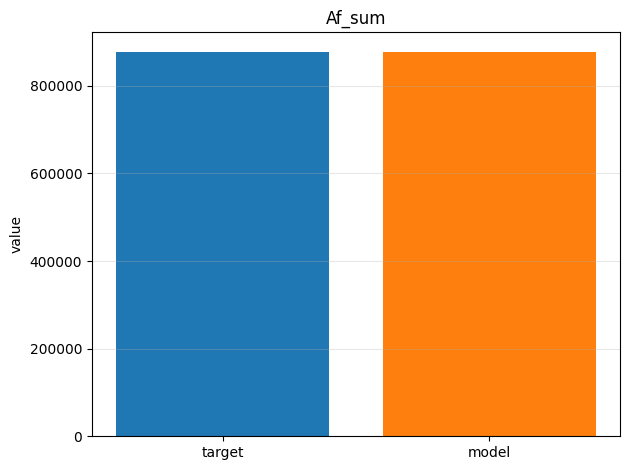

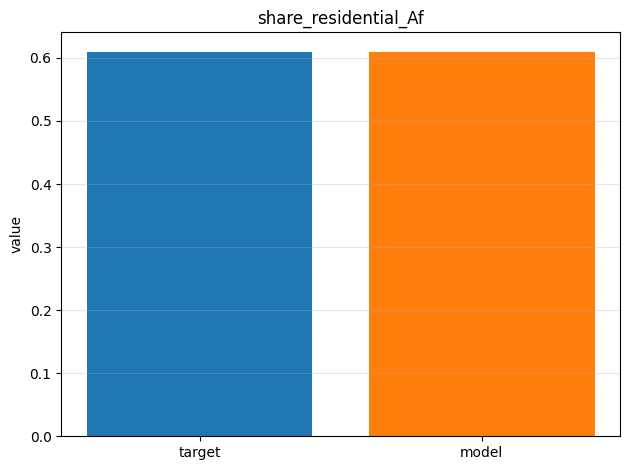

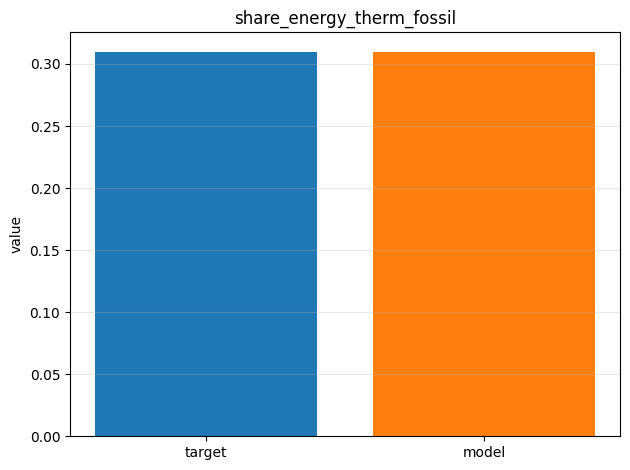

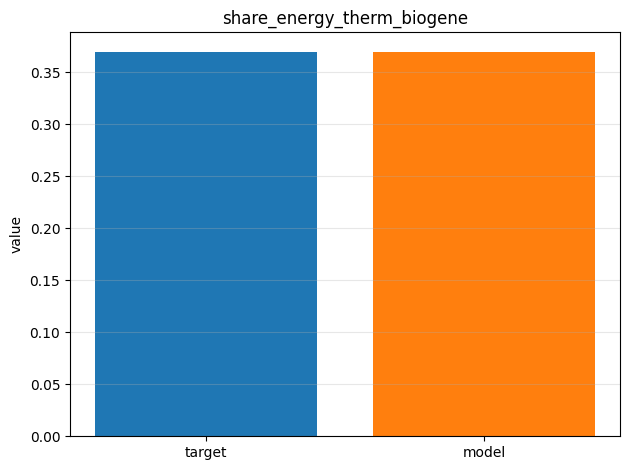

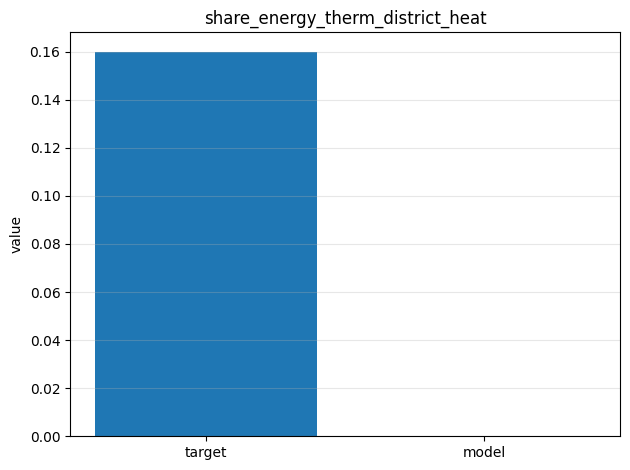

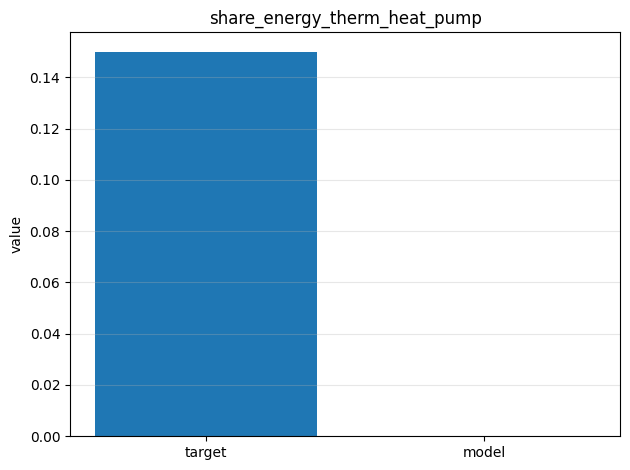

In [20]:
# ---------------------------------------------------
# 7) Analyse: Ziel vs. Modell
# ---------------------------------------------------
Af = df["Af_m2"]
usage = df["usage_simplified"]
carrier = df["energy_carrier_primary"]
E_therm = df["E_therm_MWhyr"]

Af_tot_model = float((w_sol * Af).sum())
Af_res_model = float((w_sol[usage == "residential"] * Af[usage == "residential"]).sum())
share_res_model = Af_res_model / Af_tot_model if Af_tot_model != 0 else None

results = []

# Af_total
Af_target = targets["Af_total"]
results.append({
    "constraint": "Af_total",
    "metric": "Af_sum",
    "target": Af_target,
    "model": Af_tot_model,
    "abs_error": Af_tot_model - Af_target,
    "rel_error": (Af_tot_model - Af_target) / Af_target if Af_target != 0 else None,
})

# share_residential_Af
share_res_target = targets["share_residential_Af"]
results.append({
    "constraint": "share_residential_Af",
    "metric": "share_residential_Af",
    "target": share_res_target,
    "model": share_res_model,
    "abs_error": share_res_model - share_res_target,
    "rel_error": (share_res_model - share_res_target) / share_res_target if share_res_target != 0 else None,
})

# share_energy_therm
share_energy_targets = targets["share_energy_therm"]
for cat_name, share_target in share_energy_targets.items():
    mask = carrier == cat_name
    E_cat = float((w_sol[mask.index] * E_therm[mask]).sum())
    share_model = E_cat / float((w_sol * E_therm).sum()) if float((w_sol * E_therm).sum()) != 0 else None

    results.append({
        "constraint": f"share_energy_therm_{cat_name}",
        "metric": f"share_energy_therm_{cat_name}",
        "target": share_target,
        "model": share_model,
        "abs_error": share_model - share_target,
        "rel_error": (share_model - share_target) / share_target if share_target != 0 else None,
    })

res_df = pd.DataFrame(results)
print(res_df)

# einfache Spaltendiagramme
for _, row in res_df.iterrows():
    metric = row["metric"]
    values = [row["target"], row["model"]]
    labels = ["target", "model"]

    plt.figure()
    plt.bar(labels, values, color=["tab:blue", "tab:orange"])
    plt.title(metric)
    plt.ylabel("value")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()
